In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import safetensors
from safetensors import safe_open
import torch
from pathlib import Path
import numpy as np
import random

In [7]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Baseline

In [17]:
feature_path = "/data/lux70/data/pfam/features/all.pt"
with safe_open(feature_path, "pt") as f:
    features = f.get_tensor('features')

print(features.shape)

NUM_TO_EVAL = 512
idxs = np.arange(NUM_TO_EVAL * 2)
np.random.shuffle(idxs)

idxs1 = idxs[:NUM_TO_EVAL]
idxs2 = idxs[NUM_TO_EVAL:]

gt_x1 = features[idxs1].numpy()
gt_x2 = features[idxs2].numpy()

torch.Size([11886, 32])


In [18]:
from plaid.evaluation import parmar_kid, parmar_fid, ConditionalFID

In [126]:
uncond_gt_fid = parmar_fid(gt_x1, gt_x2)
print(uncond_gt_fid)

0.00585215408011952


In [20]:
parmar_kid(gt_x1, gt_x2)

-3.000699843932253e-05

### Unconditional to Random

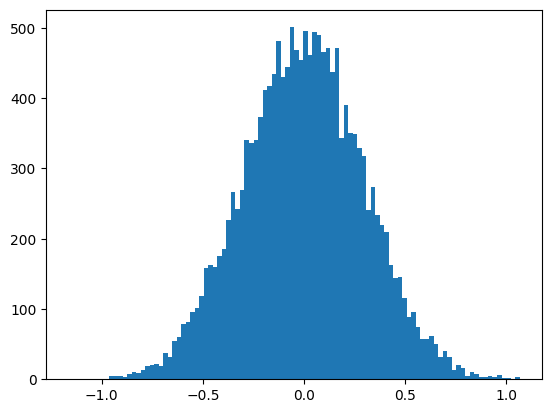

In [137]:
# from scipy.stats import beta

# # Beta distribution parameters can be tweaked for a Gaussian-like shape
# alpha, beta_param = 8, 8
# samples = beta(alpha, beta_param).rvs(1000)

# # Rescale to [-1, 1]
# bounded_samples = 2 * samples - 0.9
# print(bounded_samples.shape)
# _ = plt.hist(bounded_samples.flatten(),bins=100)


random = np.random.normal(0, 0.3, (512, 32))
_ = plt.hist(random.flatten(), bins=100)

In [138]:
random_fid = parmar_fid(random, gt_x1)
print(random_fid)

3.6432780060217427


In [50]:
parmar_fid(random, gt_x2)

3.6534859668489053

# Unconditional generation performance

In [12]:
with np.load("/data/lux70/plaid/artifacts/samples/5j007z42/f2219_o3617/240907_0658/latent.npz", allow_pickle=True) as f:
    uncond_gen = f['samples']

print(uncond_gen.shape)
uncond_gen = uncond_gen.astype(np.float32)

(1024, 128, 32)


In [13]:
idxs = np.arange(len(uncond_gen))
np.random.shuffle(idxs)
uncond_gen = uncond_gen[idxs[:NUM_TO_EVAL]]
uncond_gen = uncond_gen.mean(axis=1)
print(uncond_gen.shape)

(512, 32)


In [140]:
uncond_gen_fid = parmar_fid(gt_x1, uncond_gen)
print(uncond_gen_fid)

# just to double check, use the other chunk too
print(parmar_fid(gt_x2, uncond_gen))

0.08040021159387656
0.08127619937382213


In [22]:
print(parmar_kid(gt_x1, uncond_gen))
print(parmar_kid(gt_x2, uncond_gen))

0.002688788350547604
0.0028708816834391014


# Amass Conditional FID

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from cheap.pretrained import CHEAP_pfam_shorten_2_dim_32
cheap_pipeline = CHEAP_pfam_shorten_2_dim_32()

/homefs/home/lux70/code/cheap-proteins/src/cheap/pretrained.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_fpath)


Using tanh layer at bottleneck...
Finished loading HPCT model with shorten factor 2 and 32 channel dimensions.
Creating ESMFold embedding only model...
ESMFold embedding only model created in 33.23 seconds


In [3]:
from plaid.evaluation import ConditionalFID
from pathlib import Path
import glob
import numpy as np
import torch
import os

In [51]:
samples_dir = Path("/data/lux70/plaid/artifacts/samples/5j007z42/")

def cond_code_to_idx(cond_code: str):
    vals = cond_code.split("_")
    return int(vals[0][1:]), int(vals[1][1:])


condgen_to_true = {}
uncond_to_true = {}

batch_size = 128


for i, cond_code in enumerate(os.listdir(samples_dir)):
    function_idx, organism_idx = cond_code_to_idx(cond_code)
    timestamps = glob.glob(str(samples_dir / cond_code / "*.npz"))
    
    if len(timestamps) > 0:
        fpath = timestamps[-1]
        print(fpath)

        cond_fid = ConditionalFID(
            function_idx=function_idx,
            organism_idx=organism_idx,
            cheap_pipeline=cheap_pipeline,
            batch_size=batch_size,
            max_seq_len=256,
            max_eval_samples=512
        )
        
        with np.load(fpath, allow_pickle=True) as f:
            x = f['samples'].astype(np.float32)

        feat = x[:, -1, :, :] # take last timestep only
        feat = feat.mean(axis=1)
        res = cond_fid.run(feat)
        print(cond_code, "Generated <-> GT FID:", res)

        condgen_to_true[cond_code] = res

        # also try what happens if you do ground truth unconditional to conditional
        res = parmar_fid(feat, gt_x1)
        uncond_to_true[cond_code] = res
        print(cond_code, "Random Real <-> GT FID:", res)
            
    else:
        pass

/data/lux70/plaid/artifacts/samples/5j007z42/f2_o3617/240911_2240.npz
f2_o3617 Generated <-> GT FID: 0.22431448614522595
f2_o3617 Random Real <-> GT FID: 0.35681111653876574
/data/lux70/plaid/artifacts/samples/5j007z42/f1_o3617/240911_2010.npz
f1_o3617 Generated <-> GT FID: 0.2618252301259568
f1_o3617 Random Real <-> GT FID: 0.3003167219386905
/data/lux70/plaid/artifacts/samples/5j007z42/f7_o3617/240912_0118.npz
f7_o3617 Generated <-> GT FID: 0.2703340737507355
f7_o3617 Random Real <-> GT FID: 0.5201548885208318
/data/lux70/plaid/artifacts/samples/5j007z42/f6_o3617/240912_0028.npz
f6_o3617 Generated <-> GT FID: 0.4588000317148956
f6_o3617 Random Real <-> GT FID: 0.43771777445155036
/data/lux70/plaid/artifacts/samples/5j007z42/f11_o3617/240912_0350.npz
f11_o3617 Generated <-> GT FID: 0.10714309219338226
f11_o3617 Random Real <-> GT FID: 0.5099629354776762
/data/lux70/plaid/artifacts/samples/5j007z42/f10_o3617/240912_0257.npz
f10_o3617 Generated <-> GT FID: 0.5131101443852841
f10_o3617 R

# Plot

In [106]:
# turn into dataframe
df1 = pd.DataFrame(list(condgen_to_true.items()), columns=['Key', 'condgen_to_true'])
df2 = pd.DataFrame(list(uncond_to_true.items()), columns=['Key', 'uncond_to_true'])
combined_df = pd.merge(df1, df2, on='Key')
combined_df["GO_idx"] = combined_df['Key'].map(lambda x: cond_code_to_idx(x)[0])
combined_df["organism_index"] = combined_df['Key'].map(lambda x: cond_code_to_idx(x)[1])

# attach GO metadata
go_df = pd.read_csv("/data/lux70/data/pfam/go_index.csv")
combined_df = combined_df.merge(go_df)
combined_df = combined_df.sort_values(by="count")
combined_df['delta'] = combined_df.condgen_to_true - combined_df.uncond_to_true

In [117]:
from matplotlib import cm
from matplotlib.colors import Normalize

values = combined_df['delta']
norm = Normalize(vmin=min(values), vmax=max(values))

colormap = cm.viridis  # You can replace 'viridis' with any other matplotlib colormap
colors = colormap(norm(values))


In [115]:
combined_df

,Key,condgen_to_true,uncond_to_true,GO_idx,organism_index,Unnamed: 0,GO_term,pfam_id,GO_id,GO_level,count,delta
2,f7_o3617,0.270334,0.520155,7,3617,1914,serine-type endopeptidase inhibitor activity,PF00014,GO:0004867,function,11,-0.249821
1,f1_o3617,0.261825,0.300317,1,3617,54,ATP hydrolysis activity,PF00004,GO:0016887,function,15,-0.038491
4,f11_o3617,0.107143,0.509963,11,3617,922,growth factor activity,PF00019,GO:0008083,function,17,-0.402820
6,f4_o3617,0.314544,0.445896,4,3617,1634,protein dimerization activity,PF00010,GO:0046983,function,22,-0.131352
7,f8_o3617,0.558635,0.624222,8,3617,1931,signal transduction,PF00015,GO:0007165,process,34,-0.065587
3,f6_o3617,0.458800,0.437718,6,3617,247,RNA binding,PF00013,GO:0003723,function,118,0.021082
5,f10_o3617,0.513110,0.464838,10,3617,1629,protein binding,PF00018,GO:0005515,function,122,0.048272
0,f2_o3617,0.224314,0.356811,2,3617,52,ATP binding,PF00006,GO:0005524,function,178,-0.132497


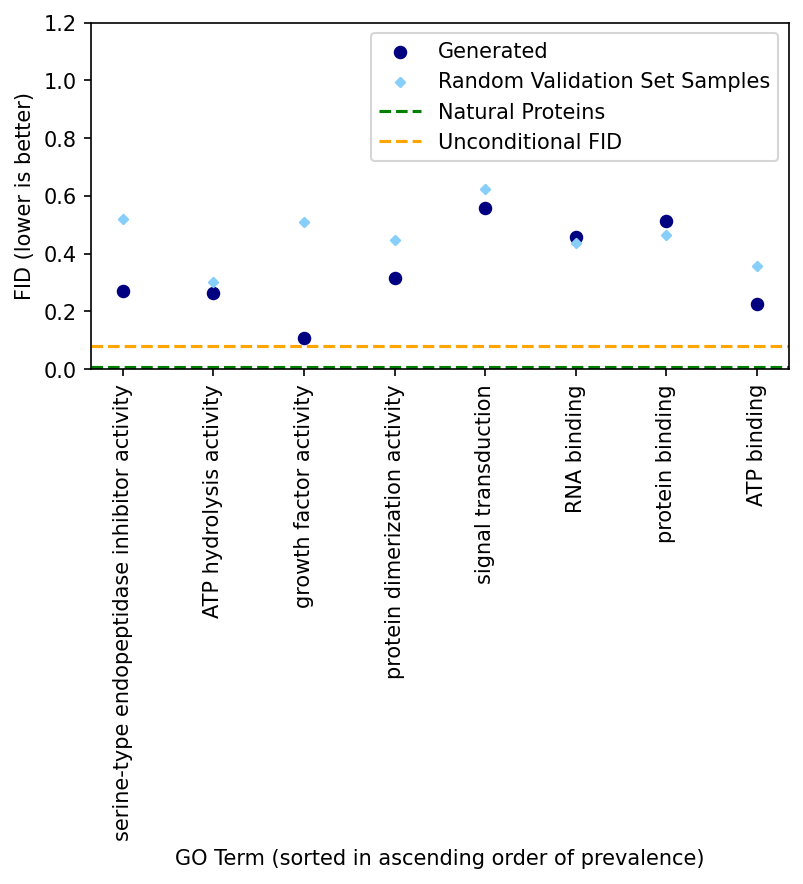

In [151]:
fig, ax = plt.subplots(1, 1, dpi=150, figsize=(6,3))
ax.scatter(np.arange(len(combined_df)), combined_df['condgen_to_true'].values, label="Generated", s=30, c="navy")
# ax.scatter(np.arange(len(combined_df)), combined_df['uncond_to_true'].values, label="Random Validation Set Samples",s=15, c=colors, marker="D")
ax.scatter(np.arange(len(combined_df)), combined_df['uncond_to_true'].values, label="Random Validation Set Samples",s=10, c="lightskyblue", marker="D")
ax.set_xticks(ticks=np.arange(len(combined_df)), labels=combined_df.GO_term.values, rotation=90)

ax.axhline(y=uncond_gt_fid, color='green', linestyle='--', label="Natural Proteins")
ax.axhline(y=uncond_gen_fid, color='orange', linestyle='--', label="Unconditional FID")


### TODO: modify upper bound on y lim as needed
### TODO: wrap text?

ax.set_ylim(0,1.2)
ax.set_xlabel("GO Term (sorted in ascending order of prevalence)")
ax.set_ylabel("FID (lower is better)")

plt.legend()